# **Libraries and environment**

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(os.getcwd())
try:
    os.chdir('../../Workshop002_Data_Engineering/')
except FileNotFoundError:
    print("""
        Posiblemente ya ejecutaste este bloque dos o más veces o tal vez el directorio está incorrecto. 
        ¿Ya ejecutaste este bloque antes y funcionó? Recuerda no ejecutarlo de nuevo. 
        ¿Estás en el directorio incorrecto? Puedes cambiarlo. 
        Recuerda el directorio donde estás:
        """)
print(os.getcwd())

/home/juanruizing/Workshop002_Data_Engineering/notebooks
/home/juanruizing/Workshop002_Data_Engineering


In [3]:
from src.database.database import creating_engine

# **Reading DF**

In [4]:
query = 'SELECT * FROM grammy_awards_raw'
df = pd.read_sql(query, creating_engine())
df.head(5)

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
0,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True
1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True
2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True
3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True
4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4810 entries, 0 to 4809
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          4810 non-null   int64 
 1   title         4810 non-null   object
 2   published_at  4810 non-null   object
 3   updated_at    4810 non-null   object
 4   category      4810 non-null   object
 5   nominee       4804 non-null   object
 6   artist        2970 non-null   object
 7   workers       2620 non-null   object
 8   img           3443 non-null   object
 9   winner        4810 non-null   bool  
dtypes: bool(1), int64(1), object(8)
memory usage: 343.0+ KB


In [6]:
df.nunique()

year              62
title             62
published_at       4
updated_at        10
category         638
nominee         4131
artist          1658
workers         2366
img             1463
winner             1
dtype: int64

# **Data Transform**

## **Columns selection**

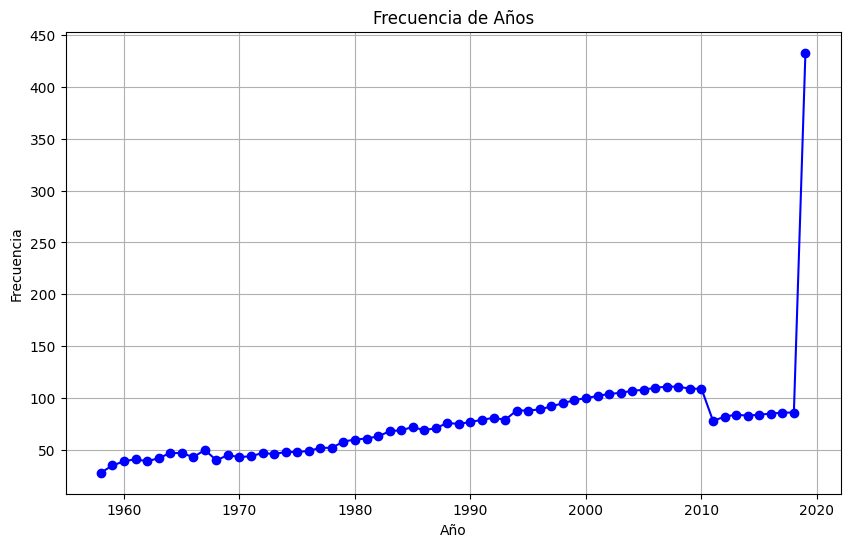

In [7]:
year_counts = df['year'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.plot(year_counts.index, year_counts.values, marker='o', linestyle='-', color='b')
plt.title('Frecuencia de Años')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [8]:
df['year'].value_counts().sort_index()

year
1958     28
1959     35
1960     39
1961     41
1962     39
       ... 
2015     84
2016     85
2017     86
2018     86
2019    433
Name: count, Length: 62, dtype: int64

El año es una columna que puede servirnos para ver el año de nominación. Podemos observar un sobresalto increíble de nominaciones en 2019 (el record es de 83 premios en 2021), lo que podría significar algún fallo en el año 2019. Por este sesgo se puede descartar un analisis posible de los años

In [9]:
columns = ['category', 'nominee', 'winner', 'year']

Debemos tener en cuenta una columna que pueda referenciar a través del merge (posiblemente es nominee por lo que se puede observar con la columna track_name del csv), con lo que podemos realizar un fuerte analisis de los grammys, sus categorías, ganadores y nominaciones por año, y manejar los nulos de manera correcta (como explicaré más abajo en el notebook)

In [10]:
df['winner'].unique()

array([ True])

In [11]:
df['year'].unique()

array([2019, 2018, 2015, 1998, 2014, 2017, 2012, 2007, 2010, 2016, 2006,
       2005, 1994, 2013, 1988, 2011, 1985, 2009, 2008, 2004, 1983, 1982,
       1977, 1981, 2003, 2002, 2001, 2000, 1999, 1996, 1997, 1969, 1995,
       1976, 1993, 1974, 1991, 1992, 1990, 1989, 1987, 1986, 1980, 1979,
       1984, 1972, 1978, 1975, 1970, 1973, 1964, 1960, 1971, 1968, 1967,
       1966, 1965, 1963, 1962, 1961, 1959, 1958])

In [12]:
print(df['year'].min())
print(df['year'].max())

1958
2019


Podríamos pensar en un fillna de la columna year, y será el año 1955 para no interrumpir el funcionamiento de los ejes en la visualización y tampoco meternos en territorio de los datos existentes. 

Lo anterior nos quiere decir que la información son solo de ganadores de los grammys, pueden tener otras nominaciones. Este solo es de ganadores, por lo que no debemos preocuparnos de elegir entre ganadores y perdedores

## **Cleaning definition**

In [13]:
df_clean = pd.DataFrame(df)

In [14]:
df_clean = df_clean[columns]

In [15]:
df_clean.head(5)

,category,nominee,winner,year
0,Record Of The Year,Bad Guy,True,2019
1,Record Of The Year,"Hey, Ma",True,2019
2,Record Of The Year,7 rings,True,2019
3,Record Of The Year,Hard Place,True,2019
4,Record Of The Year,Talk,True,2019


In [16]:
df_clean = df_clean.dropna()

In [17]:
df_clean.duplicated().sum()

0

In [18]:
duplicated_rows = df_clean[df_clean.duplicated()]
duplicated_rows.head(10)

,category,nominee,winner,year


No hay presencia de duplicados

### *Dado lo anterior tengo dos opciones:*

*Opción 1:* Ver el comportamiento de los nulos en la columna nominee y artist y eliminar los nulls.
Esto podría funcionar, ya que, si un artista es nominado, se repetira el nombre del artista en artist, o sencillamente, podríamos sospechar que no se repetirá y se colocará como null

In [19]:
df_artist_nominee = df[['category', 'nominee', 'artist', 'year']]
df_nulls_artist = df_artist_nominee[df_artist_nominee.isnull().any(axis=1)]
df_nulls_artist.head(10)

,category,nominee,artist,year
16,Song Of The Year,Bad Guy,None,2019
17,Song Of The Year,Always Remember Us This Way,None,2019
18,Song Of The Year,Bring My Flowers Now,None,2019
19,Song Of The Year,Hard Place,None,2019
20,Song Of The Year,Lover,None,2019
21,Song Of The Year,Norman F***ing Rockwell,None,2019
22,Song Of The Year,Someone You Loved,None,2019
23,Song Of The Year,Truth Hurts,None,2019
24,Best New Artist,Billie Eilish,None,2019
25,Best New Artist,Black Pumas,None,2019


No puede ser tan viable, pues se ve que hay canciones que por alguna razón, no tienen artista (tal es el caso del resultado 16, Bad Guy, de Billie Eilish)

*Opción 2:* Si tengo el nombre de la canción en nominee, puedo asegurarme con un if en el merge que sí le este apuntando a una canción
**De momento me iré con esta opción, dado que es más sencilla y tengo menos riesgos de perder datos o tener datos con nombres del artista en artist y nominee y no darme cuenta. Por ende no se aplicará un drop_duplicated**